Finding the Best Features
==================

Some attempts to pre-process the features in order to improve learning methods. 



In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

%load_ext autoreload
%autoreload 2
%matplotlib inline


import numpy as np
import pandas as pd
#import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn import decomposition as skdecomp
from sklearn import ensemble as skensemble
from sklearn import tree as sktree
from sklearn import metrics as skmetrics

import os
import time
import matplotlib.pyplot as plt

from load import DataWorker

N_FEATURE_DIMENSIONS = 20

In [3]:
def get_color_sequence(y):
    cs = []
    for value in y:
        if value == 0:
            col = "b"
        else:
            col = "r"
        cs.append(col)
    return cs

class WeightedPredictionEnsemble(skensemble.BaggingClassifier):

    def __init__(self, **kwargs):
        self.weight_one = kwargs.pop("weight_one", 1) #default value is 1
        super(WeightedPredictionEnsemble, self).__init__(**kwargs)

    def predict(self, X):
        weight_sum = np.zeros(np.shape(X)[0])
        avg_prediction = np.zeros(np.shape(X)[0])
        for clf in self.estimators_:
            results = clf.predict(X)
            results = results.astype(float)
            
            weight_sum[np.where(results == 0)] += 1
            weight_sum[np.where(results == 1)] += self.weight_one

            results[np.where(results == 1)] *= self.weight_one
            avg_prediction += results

        final = avg_prediction / weight_sum
        final[np.where(final >= 0.5)] = 1
        final[np.where(final < 1)] = 0

        return final


In [4]:
dw = DataWorker() # load all the data
x, y, test = dw.get_normalized_production_set()

# Previously, we found these hyper parametesr to be pretty good for learning
# Note, previous models were not found to be sensitive to the max_features parameters
# Therefore, a smaller value of max_features is used in dimensional reduction
best_forest = WeightedPredictionEnsemble(base_estimator=sktree.DecisionTreeClassifier(max_features=1.0, 
                                            class_weight={0:1,1:0.56}), 
                                       n_estimators=1000, 
                                       max_samples=150, 
                                       weight_one=0.56)

regular_forest = WeightedPredictionEnsemble(base_estimator=sktree.DecisionTreeClassifier(max_features=300, 
                                            class_weight={0:1,1:0.56}), 
                                       n_estimators=1000, 
                                       max_samples=150, 
                                       weight_one=0.56)

# extra random trees make a random forest with completely random splits at every node 
extra_random_forest = skensemble.ExtraTreesClassifier(n_estimators=1000, class_weight={0:1,1:0.56})

Now that the basic objects are initialized. Let's compute an extra random tree to get an initial set of about 50 features that are probably important. One of the problems of measuring feature importance is that with so many initial features, the top features can be a bit noisy. So let's do this in 2 steps. First, extract the top 50, and then extract the top 10 on decision trees run using the top 50.

Most Important Features:
[ 33  65 117 217  91  80 295  82  24 194 189  30   4 199  39  17  73  16
 272 230]


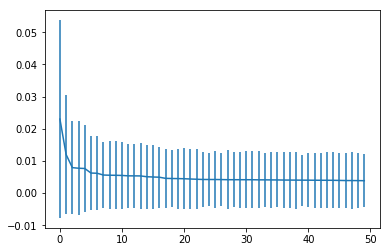

In [5]:
# Run an extra random forest on all 300 classifiers, get initial estimate of ~ 50 top features
extra_random_forest.fit(x, y)
feature_importance = np.zeros((1000,300))

for idx,est in enumerate(extra_random_forest.estimators_):
    feature_importance[idx,:] = est.feature_importances_

avg_importance = feature_importance.mean(axis=0)
sd_importance = feature_importance.std(axis=0)

sort_indices = np.argsort(avg_importance*-1)

n_importance = 50
sorted_avg = []
sorted_sd = []
for i in range(n_importance):
    sorted_avg.append(avg_importance[sort_indices[i]])
    sorted_sd.append(sd_importance[sort_indices[i]])
plt.figure()
plt.errorbar(np.arange(n_importance), sorted_avg, yerr=sorted_sd)

print("Most Important Features:")
print(sort_indices[:20]) 
# empirically, the first 5 seem to be fairly consistent, the next 10 or so can vary in order and are less consistent. 


Great, let's now recompute an extra random tree (and I guess, a regular decision tree) and see what the 10 most important features are now with this smaller subset of features.

Most Important Features:
[ 0  1  4  3  2 15 13 40  5  7  6 16  8 11 29 17 20 46 31 10]


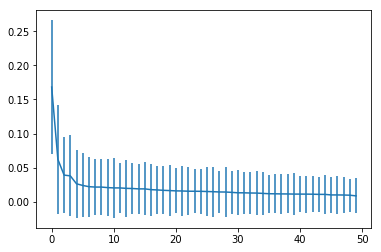

In [6]:
sorted_x = x[:,sort_indices[:n_importance]]
best_forest.fit(sorted_x, y)
feature_importance = np.zeros((1000,50))

for idx,est in enumerate(best_forest.estimators_):
    feature_importance[idx,:] = est.feature_importances_

avg_importance = feature_importance.mean(axis=0)
sd_importance = feature_importance.std(axis=0)

sort_indices = np.argsort(avg_importance*-1)

n_importance = 50
sorted_avg = []
sorted_sd = []
for i in range(n_importance):
    sorted_avg.append(avg_importance[sort_indices[i]])
    sorted_sd.append(sd_importance[sort_indices[i]])
plt.figure()
plt.errorbar(np.arange(n_importance), sorted_avg, yerr=sorted_sd)

print("Most Important Features:")
print(sort_indices[:20]) 
# empirically, the first 5 seem to be fairly consistent, the next 10 or so can vary in order and are less consistent. 


Statistics on 1000 trees
===================

In order to make this more repeatable, I computed statistics on 1000 extra random trees (`ExtraTreeClassifier`). I then isolated the top 50 features and ranked them further using a `WeightedPredictionEnsemble` and a `ExtraTreeClassifier`. First, let's load the results computed with `important_feature_statitics.py` compute the average rank of all 300 features. Looking at the plots, it looks like the first 5 features already are causing most of the decrease at each split for the Gini impurity. 

In [27]:
features_set_random = np.loadtxt("top_features.dat").astype(int)
features_set_forest = np.loadtxt("top_features_not_random.dat").astype(int)

def compute_average_ranks(features_set):
    # Given a set of features, compute the average and standard deviation for each feature's rank
    features_ranks = np.zeros((300, 1000))
    for i in range(1000):
        this_rank = np.ones(300) * 51 # default rank is 51 for bad feature
        for j in range(50):
            this_rank[features_set[i,j]] = j
        features_ranks[:,i] = this_rank
        
    avg = features_ranks.mean(axis=1)
    std = features_ranks.std(axis=1)
    return avg, std


def sort_ranks(avg, std):
    # Sort the feature ranks, return list with feature index, mean and std of importance rank
    sort_idx = np.argsort(avg)
    sort_lst = []
    for i in range(300):
        idx = sort_idx[i]
        sort_lst.append([idx, avg[idx], std[idx]])
    return sort_lst

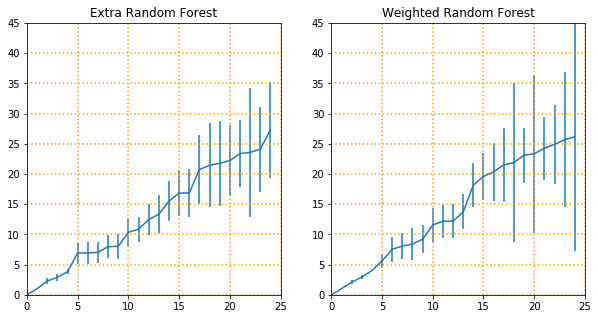

In [62]:
# Compute the average ranks and their std for each tree
random_avg, random_std = compute_average_ranks(features_set_random)
best_random = sort_ranks(random_avg, random_std)

forest_avg, forest_std = compute_average_ranks(features_set_forest)
best_forest = sort_ranks(forest_avg, forest_std)

# Plot the average ranks, look for patterns
n_plot = 25

best_random_arr = np.array(best_random)
best_forest_arr = np.array(best_forest)

plt.figure(figsize=(10,5))        
plt.subplot(1,2,1)
plt.title("Extra Random Forest")
plt.axis([0, n_plot, 0, 45])
plt.errorbar(np.arange(n_plot), best_random_arr[:n_plot,1], yerr=best_random_arr[:n_plot,2])

#plot gridlines
for i in range(0,45,5):
    plt.plot([i,i],[0, 45], linestyle=":", color="orange")
    plt.plot([0, 45],[i,i], linestyle=":", color="orange")


plt.subplot(1,2,2)
plt.title("Weighted Random Forest")
plt.axis([0, n_plot, 0, 45])
plt.errorbar(np.arange(n_plot), best_forest_arr[:n_plot,1], yerr=best_forest_arr[:n_plot,2])
#plot gridlines
for i in range(0,45,5):
    plt.plot([i,i],[0, 45], linestyle=":", color="orange")
    plt.plot([0, 45],[i,i], linestyle=":", color="orange")



Cool, so it looks like the ranks have discontinuities. I theorizie these discontinuities or jumps can probably act as good break points for selecting a smaller number of features. Clearly 20 is too big when the value of features begin to fluctuate heavily.

In [69]:
# print out the top N features
n_print_features = 5
print(np.sort(best_random_arr[:n_print_features,0]))
print(np.sort(best_forest_arr[:n_print_features,0]))

n_print_features = 6
print(np.sort(best_random_arr[:n_print_features,0]))
print(np.sort(best_forest_arr[:n_print_features,0]))

n_print_features = 10
print(np.sort(best_random_arr[:n_print_features,0]))
print(np.sort(best_forest_arr[:n_print_features,0]))

n_print_features = 14
print(np.sort(best_random_arr[:n_print_features,0]))
print(np.sort(best_forest_arr[:n_print_features,0]))

n_print_features = 20
print(np.sort(best_random_arr[:n_print_features,0]))
print(np.sort(best_forest_arr[:n_print_features,0]))

print(random_avg[30])
print(forest_avg[30])

print(random_avg[189])
print(forest_avg[189])

top5_idx = [33, 65, 91, 117, 217]
top15_idx = [16, 17, 24, 30, 33, 65, 73, 80, 82, 91, 117, 189, 199, 217, 295]

[ 33.  65.  91. 117. 217.]
[ 33.  65.  91. 117. 217.]
[ 33.  65.  91. 117. 199. 217.]
[ 33.  65.  91. 117. 217. 295.]
[ 33.  65.  80.  82.  91. 117. 189. 199. 217. 295.]
[ 17.  33.  65.  73.  80.  91. 117. 199. 217. 295.]
[ 16.  17.  24.  33.  65.  73.  80.  82.  91. 117. 189. 199. 217. 295.]
[ 16.  17.  24.  30.  33.  65.  73.  80.  82.  91. 117. 199. 217. 295.]
[ 16.  17.  24.  30.  33.  39.  65.  73.  80.  82.  91. 117. 164. 176.
 189. 194. 199. 201. 217. 295.]
[ 16.  17.  24.  30.  33.  65.  73.  80.  82.  91. 117. 167. 189. 194.
 199. 214. 217. 230. 237. 295.]
16.84
12.174
8.015
18.146


Some interesting break points emerge. First 5 features are consistent, this would probably be enough for a super simple model. Then differences emerge between the methods. The key difference seems to be Feature 30 and 189. Feature 189 probably contains some hidden information that is gleamed when using a more random method, but feature 30 provides more consistent splits. Let's include both for an even 15 features, as well as the first 5 features. Maybe after outlier removal, the random feature could have more information. We can then train several trees using these different sets of features and combine them in some sort of voting result.

In [75]:
# Set up the training data
x_top5 = x[:,top5_idx]
x_top15 = x[:,top15_idx]

full_forest = WeightedPredictionEnsemble(base_estimator=sktree.DecisionTreeClassifier(max_features=300, 
                                            class_weight={0:1,1:0.56}), 
                                       n_estimators=1000, 
                                       max_samples=150, 
                                       weight_one=0.56)

forest_top5 = WeightedPredictionEnsemble(base_estimator=sktree.DecisionTreeClassifier(max_features=1.0, 
                                            class_weight={0:1,1:0.56}), 
                                       n_estimators=1000, 
                                       max_samples=150, 
                                       weight_one=0.56)

forest_top15 = WeightedPredictionEnsemble(base_estimator=sktree.DecisionTreeClassifier(max_features=1.0, 
                                            class_weight={0:1,1:0.56}), 
                                       n_estimators=1000, 
                                       max_samples=150, 
                                       weight_one=0.56)

extra_top5 = skensemble.ExtraTreesClassifier(n_estimators=1000, class_weight={0:1,1:0.56})

extra_top15 = skensemble.ExtraTreesClassifier(n_estimators=1000, class_weight={0:1,1:0.56})

all_forests = [full_forest, forest_top5, forest_top15, extra_top5, extra_top15]
all_training_data = [x, x_top5, x_top15, x_top5, x_top15]

In [78]:
for frst,tdat in zip(all_forests, all_training_data):
    x_train, x_val, y_train, y_val = train_test_split(tdat, y, test_size=0.2, random_state=23, stratify=y) 
    frst.fit(x_train, y_train)
    y_predicted = frst.predict(x_val)
    score = skmetrics.accuracy_score(y_val, y_predicted)
    print(score)
    dw.print_fraction_predictions(y_predicted)

0.6
Classified as zero: 26, 0.520000
 Classified as one: 24, 0.480000
0.78
Classified as zero: 19, 0.380000
 Classified as one: 31, 0.620000
0.66
Classified as zero: 25, 0.500000
 Classified as one: 25, 0.500000
0.72
Classified as zero: 8, 0.160000
 Classified as one: 42, 0.840000
0.72
Classified as zero: 8, 0.160000
 Classified as one: 42, 0.840000


Okay, so it seems like some of these classifiers are effectivelky the same. Let's pick three of the ones that seem relatively different and maybe their average will work out. Let's pick `forest_top5`, `forest_top15` and `extra_top5` as they seem to be good at different things and there are already models that seem to be good at classifying different features.

In [90]:
final_jungle = [forest_top5, forest_top15, extra_top5]
final_training_data = [x_top5, x_top15, x_top5]

test_top5 = test[:,top5_idx]
test_top15 = test[:,top15_idx]
final_test_data = [test_top5, test_top15, test_top5]

final_weights = np.ones(len(final_jungle))

# train the models
for frst,tdat in zip(final_jungle, final_training_data):
    frst.fit(tdat, y)

# Now, make new predictions
all_predictions = []
for frst,tdat in zip(final_jungle, final_test_data):
    all_predictions.append(frst.predict(tdat))

# and average the predictions and see what we get
avg_predictions = np.zeros(np.shape(all_predictions[0]))
for prediction,weight in zip(all_predictions, final_weights):
    dw.print_fraction_predictions(prediction)
    avg_predictions += prediction*weight

avg_predictions /= np.sum(final_weights)

final_predictions = np.zeros(np.shape(avg_predictions))
final_predictions[np.where(avg_predictions > 0.5)] = 1

dw.output_results(final_predictions, "submission_random_jungleA.csv")

Classified as zero: 8486, 0.429671
 Classified as one: 11264, 0.570329
Classified as zero: 8251, 0.417772
 Classified as one: 11499, 0.582228
Classified as zero: 5458, 0.276354
 Classified as one: 14292, 0.723646
Classified as zero: 7344, 0.371848
 Classified as one: 12406, 0.628152


Submitting this combined result, I ended up with having a score of 0.716, which was a mild improvement from the previous score of 0.699. Well, let's remove outliers now that we have a good low-dimensional set of features and see what happens. First, let's save the information here to make it easier for other members in the group to work with.

In [95]:
dw.output_features(top5_idx, "top5")
dw.output_features(top15_idx, "top15")
np.savetxt("top5_features.txt", best_forest_arr[:5,0], fmt="%d")
np.savetxt("top15_features.txt", top15_idx, fmt="%d")

Outlier Removal
=============

Use isolation forest to remove outliers. Remove specifically in the most important feature dimensions. Then remove outliers if they make sense. 